In [3]:
import whisper
import sounddevice as sd
import soundfile as sf
import tempfile
import threading
import time
import pyttsx3
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
import threading
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mediapipe as mp
import time
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/luffy_sama/Desktop/Workspace/EE_782/Assignment_2/deepface310/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
# -------- Configuration --------
MODEL_NAME = "medium.en"
RECORD_SECONDS = 4
SAMPLE_RATE = 16000
WAKE_PHRASES = ["guard my room", "guard my room please", "guard", "activate guard", "start guard"]
DISARM_PHRASES = ["stop guard", "disarm", "deactivate guard", "stop guard please", "stop"]

In [5]:
# Set default audio input device (change index if needed)
try:
    sd.default.device = sd.query_devices(kind='input')['name']
except Exception as e:
    print("[audio] Could not set default device:", e)

# persistent webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("[webcam] ERROR: cannot open webcam")

def record_chunk(seconds=RECORD_SECONDS, samplerate=SAMPLE_RATE):
    print(f"[audio] recording {seconds}s...")
    try:
        recording = sd.rec(int(seconds * samplerate), samplerate=samplerate, channels=1)
        sd.wait()
    except Exception as e:
        print("[audio] ERROR:", e)
        return None
    tmp = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    sf.write(tmp.name, recording, samplerate)
    return tmp.name

def contains_phrase(text, phrases):
    text = text.lower()
    return any(p in text for p in phrases)

def get_webcam_frame():
    ret, frame = cap.read()
    if not ret:
        return None
    return frame

out_widget = widgets.Output()
display(out_widget)
cap.release()


Output()

In [6]:
import mediapipe as mp
import cv2
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

mp_face_mesh = mp.solutions.face_mesh

BASE_DIR = "enrolled_faces"
os.makedirs(BASE_DIR, exist_ok=True)


def extract_embedding(image_path):
    """Extract a 3D face landmark embedding from an image."""
    img = cv2.imread(image_path)
    if img is None:
        print("[enroll] Could not read image:", image_path)
        return None

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            print("[enroll] No face found in", image_path)
            return None
        landmarks = results.multi_face_landmarks[0].landmark
        emb = np.array([[lm.x, lm.y, lm.z] for lm in landmarks]).flatten()
        emb = emb / np.linalg.norm(emb)
        return emb

def enroll_face(person_name, image_paths):
    person_dir = os.path.join(BASE_DIR, person_name)
    os.makedirs(person_dir, exist_ok=True)

    for i, path in enumerate(image_paths):  # keep enumerate
        if not os.path.exists(path):
            print("[enroll] File not found:", path)
            continue
        emb = extract_embedding(path)
        if emb is not None:
            np.save(os.path.join(person_dir, f"{i}.npy"), emb)
            print(f"[enroll] Saved embedding {i+1} for {person_name}")
    print(f"[enroll] Completed enrollment for {person_name} ✅")



In [7]:
# enroll_face("Vishal", ["enrolled_faces/vishal1.jpg", "enrolled_faces/vishal2.jpg"])

In [8]:
def recognize_face_with_score(frame, threshold=0.9):
    """
    Recognize face from frame by comparing with all enrolled faces.
    Uses majority vote: counts embeddings exceeding threshold per person.
    Returns the person with the maximum count.
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return "Unknown", frame, 0.0

        landmarks = results.multi_face_landmarks[0].landmark
        emb = np.array([[lm.x, lm.y, lm.z] for lm in landmarks]).flatten()
        emb = emb / np.linalg.norm(emb)

        best_name, best_count, best_sim = "Unknown", 0, 0.0

        for person_name in os.listdir(BASE_DIR):
            person_dir = os.path.join(BASE_DIR, person_name)
            if not os.path.isdir(person_dir):
                continue

            count_above_thresh = 0
            sims = []

            for f in os.listdir(person_dir):
                if not f.endswith(".npy"):
                    continue
                known_emb = np.load(os.path.join(person_dir, f))
                sim = cosine_similarity([emb], [known_emb])[0][0]
                sims.append(sim)
                if sim >= threshold:
                    count_above_thresh += 1

            # Majority vote
            if count_above_thresh > best_count:
                best_count = count_above_thresh
                best_name = person_name
                if sims:
                    best_sim = max(sims)

        # No one exceeded threshold
        if best_count == 0:
            best_name = "Unknown"
            best_sim = 0.0

        return best_name, frame, best_sim


In [9]:
from langchain_community.chat_models import ChatOllama
from gtts import gTTS
from playsound import playsound

ollama_client = ChatOllama(
    model="llama3",   # replace with your local Ollama model name
    base_url="http://localhost:11434"  # default Ollama local server
)

import tempfile

def speak(text):
    with tempfile.NamedTemporaryFile(delete=True, suffix=".mp3") as fp:
        tts = gTTS(text=text, lang='en')
        tts.save(fp.name)
        playsound(fp.name)

def get_response_from_ollama(prompt):
    """Get response from local Ollama model."""
    response = ollama_client.predict(prompt)
    return response




/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_14768/1498403772.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  ollama_client = ChatOllama(


In [ ]:
class GuardAgent:
    def __init__(self, cap):
        print("[init] loading Whisper model:", MODEL_NAME)
        self.model = whisper.load_model(MODEL_NAME)
        self.tts = pyttsx3.init()
        self.tts.setProperty("rate", 150)
        self.guard_mode = False
        self.cap = cap
        self.last_name = None
        self.last_detect_time = 0
        self.guard_thread = None
        self.guard_stop_event = threading.Event()
        self.intruder_levels = {}
        self.level_timers = {}
        pygame.mixer.init()
        self.alarm_file = "alarm.mp3"
        self.alarm_playing = False


    def listen_and_toggle(self):
        wav_path = record_chunk()
        if not wav_path: return
        try:
            result = self.model.transcribe(wav_path, language="en")
            transcript = result.get("text", "").strip().lower()
        except Exception as e:
            print("[transcribe] error:", e)
            transcript = ""
        finally:
            os.remove(wav_path)

        print("[heard]", transcript)

        if not self.guard_mode and contains_phrase(transcript, WAKE_PHRASES):
            self.guard_mode = True
            self.tts.say("Guard mode activated.")
            self.tts.runAndWait()
            self.guard_stop_event.clear()
            self.guard_thread = threading.Thread(target=self.run_guard_mode, daemon=True)
            self.guard_thread.start()

        elif self.guard_mode and contains_phrase(transcript, DISARM_PHRASES):
            self.guard_mode = False
            self.tts.say("Guard mode deactivated.")
            self.tts.runAndWait()
            self.guard_stop_event.set()
            if self.guard_thread:
                self.guard_thread.join()

    def run_guard_mode(self):
        print("[guard] Running face detection...")
        mp_face = mp.solutions.face_detection
        plt.ion()
        fig, ax = plt.subplots()

        with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as detector:
            while self.guard_mode and not self.guard_stop_event.is_set():
                ret, frame = self.cap.read()
                if not ret:
                    break

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = detector.process(rgb)

                intruder_present = False  # Track if any unknown intruder is present in this frame

                if results.detections:
                    for det in results.detections:
                        bboxC = det.location_data.relative_bounding_box
                        ih, iw, _ = frame.shape
                        x1 = int(bboxC.xmin * iw)
                        y1 = int(bboxC.ymin * ih)
                        w = int(bboxC.width * iw)
                        h = int(bboxC.height * ih)
                        x2 = x1 + w
                        y2 = y1 + h

                        # Draw rectangle
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # Crop face for recognition
                        face_crop = frame[max(0, y1):min(ih, y2), max(0, x1):min(iw, x2)]
                        name = "Unknown"
                        sim = 0

                        if face_crop.size > 0:
                            name, _, sim = recognize_face_with_score(face_crop)

                        # Draw name
                        cv2.putText(frame, f"{name}", (x1, y2 + 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                                    (0, 255, 0) if name != "Unknown" else (0, 0, 255), 2)

                # STOP alarm if no intruder detected in this frame
                if not intruder_present and self.alarm_playing:
                    pygame.mixer.music.stop()
                    self.alarm_playing = False

                # Display frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                ax.clear()
                ax.imshow(frame_rgb)
                ax.axis('off')
                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)

        plt.close(fig)

[init] loading Whisper model: medium.en


I0000 00:00:1759973092.163219       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/Users/luffy_sama/Desktop/Workspace/EE_782/Assignment_2/deepface310/lib/python3.10/site-packages/google/protobuf/symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1759973092.182410       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
Exception in thread Thread-4 (run_guard_mode):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.18_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/luffy_sama/Desktop/Workspace/EE_782/Assignment_2/deepface310/lib/python3.10/site-pa

[init] Guard mode activated automatically.
Say 'stop guard' to stop.

[exit] KeyboardInterrupt received — cleaning up.
[exit] done.


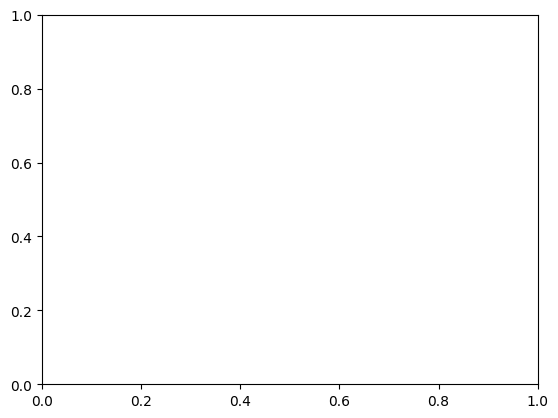

In [ ]:
# def main():
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("[webcam] cannot open webcam")
#         return
#     agent = GuardAgent(cap)
#     print("Say 'guard my room' to activate. Say 'stop guard' to stop.")

#     try:
#         while True:
#             agent.listen_and_toggle()
#             # Optional: show webcam preview when not in guard mode
#             if not agent.guard_mode:
#                 frame = get_webcam_frame()
#                 if frame is not None:
#                     _, encoded_img = cv2.imencode('.png', frame)
#                     img_bytes = encoded_img.tobytes()
#                     with out_widget:
#                         clear_output(wait=True)
#                         display(widgets.Image(value=img_bytes, format='png', width=640, height=480))
#             time.sleep(0.1)
#     except KeyboardInterrupt:
#         print("\n[exit] KeyboardInterrupt received — cleaning up.")
#     finally:
#         if hasattr(agent, 'alarm_playing') and agent.alarm_playing:
#             pygame.mixer.music.stop()
#             agent.alarm_playing = False
#         cap.release()
#         print("[exit] done.")

# main()

# def main():
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("[webcam] cannot open webcam")
#         return

#     agent = GuardAgent(cap)

#     # Force guard mode ON immediately
#     agent.guard_mode = True
#     agent.guard_stop_event.clear()
#     agent.guard_thread = threading.Thread(target=agent.run_guard_mode, daemon=True)
#     agent.guard_thread.start()

#     print("[init] Guard mode activated automatically.")
#     print("Say 'stop guard' to stop.")

#     try:

#         while True:
#             if not agent.guard_mode:
#                 frame = get_webcam_frame()
#                 if frame is not None:
#                     _, encoded_img = cv2.imencode('.png', frame)
#                     img_bytes = encoded_img.tobytes()
#                     with out_widget:
#                         clear_output(wait=True)
#                         display(widgets.Image(value=img_bytes, format='png', width=640, height=480))

#             time.sleep(0.1)
#     except KeyboardInterrupt:
#         print("\n[exit] KeyboardInterrupt received — cleaning up.")
#     finally:
#         if hasattr(agent, 'alarm_playing') and agent.alarm_playing:
#             pygame.mixer.music.stop()
#             agent.alarm_playing = False
#         cap.release()
#         print("[exit] done.")

# main()

